In [82]:
import pandas as pd
import numpy as np 
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
plt.rcParams.update(plt.rcParamsDefault)
plt.rcdefaults()
from pandas.plotting import table
import math

In [83]:
def plotar_grafico_top_10(arr_emails,parte_titulo):
    vetores_arr_todos = uniao_vetores(lista_emails=arr_emails[:,0])
    df_todos = pd.DataFrame(vetores_arr_todos,index=['Contagem']).transpose()
    df_top_10 = df_todos.sort_values(by=['Contagem'], ascending=False)[:10]
    qtd_emails_SPAM = (arr_emails[:,1]=='SPAM').sum()
    qtd_emails_NAO_SPAM = (arr_emails[:,1]=='NAO_SPAM').sum()
    legenda = [
        ['Palavras Únicas',df_todos.shape[0]],
        ['Total de Palavras',df_todos['Contagem'].sum()],
        ['Quantidade de emails',arr_emails.shape[0]],
        ['Quantidade de emails SPAM',qtd_emails_SPAM],
        ['Quantidade de emails NAO SPAM',qtd_emails_NAO_SPAM],
    ]

    
    df_legenda = pd.DataFrame(legenda,columns=['Indicador','Quantidade']).set_index('Indicador')

    fig = plt.figure(figsize=(12, 6), dpi=80)

    ax = fig.add_subplot(111)    

    plt.bar(x=df_top_10.index,height=df_top_10['Contagem'].values)

    plt.title('Top 10 palavras mais frequentes - {}'.format(parte_titulo),fontdict = {'fontsize':15,'fontweight':'bold'})
    plt.ylabel('Ocorrências',fontdict = {'fontsize':14,'fontweight':'bold'})
    plt.xlabel('Palavras',fontdict = {'fontsize':14,'fontweight':'bold'})

    # plt.table(df_legenda, loc="upper right", colWidths=[0.1, 0.1, 0.2])
    tabela = plt.table(cellText=df_legenda.values,
                        colWidths=[.2],
                        rowLabels=df_legenda.index,
                        cellLoc='center',
                        colLabels=['Indicador','Quantidade'],
                        rowColours=['gray']*len(legenda),
                        colColours=['gray'],
                        loc='upper right')
    tabela.auto_set_font_size(False)
    tabela.set_fontsize(10)
    tabela.scale(1, 2)

    plt.show()

def gera_nuvem_palavras(vetores_arr,parte_titulo):
    texto_0 = ' '.join(list(vetores_arr))
    wordcloud = WordCloud().generate(texto_0)

    # plota a nuvem de palavras:
    plt.figure(figsize=(20, 15), dpi=80)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Nuvem de palavras - {}'.format(parte_titulo),fontdict = {'fontsize':30,'fontweight':'bold'})
    plt.axis("off")
    plt.show()

def gera_lista_stop_words(path):    
    todas_palavras = ''
    with open(path, 'r') as f:
        todas_palavras = f.read()
    todas_palavras = todas_palavras.upper()
    return todas_palavras.split('\n')
    
def retorna_lista(path, label):    
    texto_inteiro = []
    email = ''
    email_teste = ''
    with open(path, 'r') as f:
        try:
            while True:
                linha = next(f)
                if (linha.find('De: ') >= 0 and linha.find('@') >=0):                    
                    cabecalho = True
                    while cabecalho:
                        linha = next(f)
                        if linha.find('Assunto: ') < 0 and \
                            linha.find('Data: ') < 0 and \
                            linha.find('Para: ') < 0 and \
                            linha.find('Cco: ') < 0 and \
                            linha.find('Responder A: ') < 0:
                            cabecalho = False

                    email = email.replace('\n','').upper()
                    texto_inteiro.append(np.array([email,label]))
                    email = linha
                else:
                    email+=linha
        except StopIteration:
            email = email.replace('\n','')
            texto_inteiro.append(np.array([email,label]))
            texto_inteiro.pop(0)
            return np.array(texto_inteiro)
            
def bag_of_words(lista_palavras: list):
    bow = {}

    # Apagar o caracter s no final da palavra
    padrao_busca = r's+$'
    substituir_caracteres(padrao_busca=padrao_busca,lista_palavras=lista_palavras)

    for palavra in lista_palavras:
        if palavra != '':
            try:
                bow[palavra]+=1        
            except:
                bow[palavra]=1
    return bow

# retorno um vetor de todos os palavras no texto (se tiver palavras repetidas, aqui aparecerao todas as repeticoes)
def vetorizar(texto: str):
    # faço split da string através de sequência de caracteres especiais (atraves de busca via REGEX) e já deixo em um numpy array
    lista_palavras = np.array(re.split('\W+|_+',texto))
    # retorno um array que não possui dados em branco (pode ocorrer com o split acima)
    return lista_palavras[np.where(lista_palavras!="")]

def uniao_vetores_com_repeticao(lista_emails):
    emails_concateados = ''
    for email in lista_emails:
        emails_concateados+=(' ' + email)
    return vetorizar(emails_concateados)

def uniao_vetores(lista_emails):
    emails_concateados = ''
    for email in lista_emails:
        emails_concateados+=(' ' + email)
    return bag_of_words(vetorizar(emails_concateados))

def split_base(todos_emails, porc_treinamento):
    # embaralho os emails
    np.random.shuffle(todos_emails)
    qtd_treinamento = int(todos_emails.shape[0]*porc_treinamento)
    arr_treinamento = todos_emails[:qtd_treinamento]
    arr_teste = todos_emails[qtd_treinamento:]
    return arr_treinamento, arr_teste
    

def gera_serie_porcentagem_acumulada(arr_qtd_palavras):
    # arr_qtd_palavras: numpy array
    qtd_total = np.sum(arr_qtd_palavras)    
    arr_porc_acum = []
    qtd_acum = 0
    for qtd in arr_qtd_palavras:
        qtd_acum+=qtd
        arr_porc_acum.append(qtd_acum/qtd_total)
    return np.array(arr_porc_acum)

    

# Gera um numpy array com atributos nas colunas e linhas sendo cada instancia (email)
def vetorizar_restrito(vetor_base_treinamento, arr_treinamento):
    # inicalmente uma lista que guardará os vetores de cada instância (corpo de email)
    arr_treinamento_vetorizado = []
    for email_id in range(arr_treinamento.shape[0]):
        # Crio o vetor da instância baseado nos atributos do vetor de treinamento base
        vetor_email = np.zeros(vetor_base_treinamento.shape[0])

        # contabilizar a quantidade de ocorrências de cada vetor
        for palavra in vetorizar(arr_treinamento[:,0][email_id]):
            try:
                id_vetor_base_treinamento = np.where(vetor_base_treinamento==palavra)[0][0]
                # Estou considerando a soma das ocorrêncuas de cada atributo nesta instância
                vetor_email[id_vetor_base_treinamento]+=1
            except:
                pass
        arr_treinamento_vetorizado.append(vetor_email)
    return np.array(arr_treinamento_vetorizado)

# Cálculo das probabilidades priores (probabilidade de ser SPAM ou NAO_SPAM ) no conjunto de treinamento
def calculo_probabilidades(arr_treinamento,palavras_sem_stop_words):
    label_h = [0,0]
    prob_hipoteses = [0,0]
    soma_hip = [0,0]
    soma_palavras_hip = [0,0]

    label_h[0] = 'SPAM'
    label_h[1] = 'NAO_SPAM'

    tamanho_vocabulario = palavras_sem_stop_words.shape[0]

    # Gera um numpy array com atributos nas colunas e linhas sendo cada instancia (email)
    arr_treinamento_vetorizado = vetorizar_restrito(vetor_base_treinamento = palavras_sem_stop_words, arr_treinamento = arr_treinamento)
    
    for pos in range(2):
        soma_hip[pos] = (arr_treinamento[:,1]==label_h[pos]).sum()
        prob_hipoteses[pos] = soma_hip[pos]/arr_treinamento.shape[0]
        soma_palavras_hip[pos] = arr_treinamento_vetorizado[arr_treinamento[:,1]==label_h[pos]].sum()


    # prob_cond_atr_presenca_hip[atributo][valor do atributo = 0 ou 1][valor da hipotese = 0 ou 1]
    prob_cond_atr_presenca_hip = np.zeros((arr_treinamento_vetorizado.shape[1],2))

    for atributo_id in range(arr_treinamento_vetorizado.shape[1]):
        for hip_id in range(0,2):
            # somo a qtd de ocorrencias da palavra
            soma_col = arr_treinamento_vetorizado[arr_treinamento[:,1]==label_h[hip_id]][:,atributo_id].sum()            
            prob_cond_atr_presenca_hip[atributo_id][hip_id] = (soma_col+1)/(soma_palavras_hip[pos]+tamanho_vocabulario)
    return prob_hipoteses, prob_cond_atr_presenca_hip

# Encontra um padrao via regex e devolve um array de true e false para ajudar na selecao das instancias
def remover_padroes_regex(padrao_busca,numpy_array):
    def funcao_busca(x):
        if re.search(padrao_busca,x):
            return 1
        else:
            return 0
    funcao_vetorizada = np.vectorize(funcao_busca)
    resultado_true_false = funcao_vetorizada(numpy_array)==0
    return resultado_true_false

def remover_padroes_funcao(funcao_que_remove_um_padrao,condicao_remocao,numpy_array):
    def funcao_busca(x):
        return funcao_que_remove_um_padrao(x)!=condicao_remocao
    funcao_vetorizada = np.vectorize(funcao_busca)
    resultado_true_false = funcao_vetorizada(numpy_array)
    return resultado_true_false

def substituir_caracteres(padrao_busca,lista_palavras):
    for id_palavra,palavra in enumerate(lista_palavras):
        if (re.search(padrao_busca,palavra)):
            lista_palavras[id_palavra] = re.sub(padrao_busca,'', palavra)

def previsao(stop_words_resultante,arr_teste, prob_hipoteses, prob_cond_atr_presenca_hip):

    # Para prever
    # 1 - para cada instancia do teste, transformar em um vetor baseado no vetor base do treinamento
    # 2 - calcular a probabilidade de ser h1 com base no vetor resultante acima
    # 3 - calcular a probabilidade de ser h2 com base no vetor resultante acima
    # 4 - verificar qual o maior entre (2) e (3)
    # 5 - previsao será a hipótese resultante de (4)
    # 6 - utilizado log na base 2 sobre as probabilidades condicionais e das hipoteses para somar os logs ao inves de multiplicar as suas probabilidades. Com isso, evita-se trabalhar numeros infintesimais

    # Transformo o conjunto de testes em um arry baseado nos mesmos vetores de palavras utilizados pelo conjunto de treinamento
    arr_teste_vetorizado = vetorizar_restrito(vetor_base_treinamento = stop_words_resultante[:,0], arr_treinamento = arr_teste)

    # Gero um array vazio para armazenar as probabilidades geradas pelo modelo
    p_h = np.zeros((arr_teste_vetorizado.shape[0],2))
    # Gero um array vazio para armazenar o resultado da previsão (SPAM, NAO_SPAM, ZERO, IGUAL)
    arr_previsao = np.empty(arr_teste_vetorizado.shape[0], dtype='object')
    p_h[:,0] = math.log(prob_hipoteses[0],2)
    p_h[:,1] = math.log(prob_hipoteses[1],2)

    for email_teste_id in range(arr_teste_vetorizado.shape[0]):
        for attr_id, presenca in enumerate(arr_teste_vetorizado[email_teste_id]):
            for hip_valor in range(2):
                if (presenca > 0):
                    p_h[email_teste_id][hip_valor]+=math.log(prob_cond_atr_presenca_hip[attr_id][hip_valor],2)
        if p_h[email_teste_id][0] > p_h[email_teste_id][1]:
            arr_previsao[email_teste_id]='SPAM'
        else:
            arr_previsao[email_teste_id]='NAO_SPAM'

    # Crio um array com probabiliades de ser SPAM e NAO_SPAM ao inves de registrar o score do Naive Bayes
    p_h_porcentagem = np.append( (1 - p_h[:,0]/(p_h[:,0]+p_h[:,1])).reshape(-1,1) , (1 - p_h[:,1]/(p_h[:,0]+p_h[:,1])).reshape(-1,1) ,axis=1)

    # Funcao para consertar o nan resultante da divisao por zero (ocorre apenas quando o modelo resulta em score 0 tanto para ser SPAM quanto para ser NAO_SPAM -> problema de multiplicacoes por numeros muito pequenos)
    def adaptar_NAN(x):
        if (not np.isfinite(x)):
            return .5
        return x
    adaptar_NAN_vetor = np.vectorize(adaptar_NAN)
    # p_h_porcentagem = adaptar_NAN_vetor(p_h_porcentagem)
    p_h = adaptar_NAN_vetor(p_h)     
          
    # return p_h_porcentagem, arr_previsao
    return p_h, arr_previsao


# Calculo da acuracidade
def retorna_acuracidade(arr_resultados_previsao, arr_resultados_teste):
    return (arr_resultados_previsao == arr_resultados_teste).sum()/arr_resultados_teste.shape[0]

def matriz_confusao_outros_indicadores(arr_previsao, arr_teste , positivo, negativo):
    verdadeiro_positivo = (arr_previsao[arr_teste[:,1]==positivo]==positivo).sum()
    falso_positivo = (arr_previsao[arr_teste[:,1]==negativo]==positivo).sum()
    verdadeiro_negativo = (arr_previsao[arr_teste[:,1]==negativo]==negativo).sum()
    falso_negativo = (arr_previsao[arr_teste[:,1]==positivo]==negativo).sum()

    # previsao nas linhas
    # dados de teste nas colunas 

    matriz_confusao = [
        [verdadeiro_positivo,falso_negativo],
        [falso_positivo,verdadeiro_negativo]
    ]

    # taxa verdadeiro positivo
    tvp = verdadeiro_positivo/(verdadeiro_positivo+falso_negativo)
    
    # taxa falso positivo
    tfp = falso_positivo/(falso_positivo+verdadeiro_negativo)
    
    # Especifidade
    esp = 1 - tfp

    # precisao
    pr = verdadeiro_positivo/(verdadeiro_positivo+falso_positivo)

    # Acuracia
    ac = (verdadeiro_positivo + verdadeiro_negativo) / arr_teste.shape[0]

    medida_f = 2 * (pr * tvp) / (pr + tvp)

    outros_indicadores = [
        ['Taxa Verdadeiro Positivo',tvp],
        ['Taxa Falso Positivo',tfp],
        ['Especifidade',esp],
        ['Precisao',pr],
        ['Acuracia',ac],
        ['Medida-f',medida_f],
    ]

    matriz_confusao = pd.DataFrame(matriz_confusao, columns=['SPAM','NAO_SPAM'], index=['SPAM','NAO_SPAM'])

    return matriz_confusao , outros_indicadores

def gera_matriz_curva_ROC(p_h_porcentagem,arr_teste):
    # Criacao da curva ROC
    # Usei o algoritmo 2 do documento:
    # http://www.blogspot.udec.ugto.saedsayad.com/docs/ROC101.pdf

    df = pd.DataFrame(p_h_porcentagem[:,0],columns=['Score'])
    df['y_teste'] = pd.DataFrame(arr_teste[:,1],columns=['y_teste'])
    df = df.sort_values(by=['Score'], ascending=False).reset_index(drop=True)
    P = (df['y_teste']=='SPAM').sum()
    N = (df['y_teste']=='NAO_SPAM').sum()
    FP = TP = 0
    R = []
    f_prev = 0
    AUC = 0
    for i in range(df.shape[0]):
        R.append( [ FP/N , TP/P ] )
        f_prev = df['Score'][i]
        if (df['y_teste'][i] == 'SPAM'):
            TP+=1
        else:
            FP+=1
        if (i != 0):
            # Area do trapezio = altura * (base maior + base menor) / 2
            AUC += (R[i][0]-R[i-1][0]) * (R[i][1]+R[i-1][1])/2
    R.append( [ FP/N , TP/P ] )
    AUC += (R[i][0]-R[i-1][0]) * (R[i][1]+R[i-1][1])/2

    arr_R = np.array(R)
    return arr_R, AUC


def gerar_matriz_confusao_outros_indicadores_curva_ROC(arr_previsao, arr_teste, p_h_porcentagem):

    verdadeiro = 'SPAM'
    negativo = 'NAO_SPAM'
    matriz_confusao , outros_indicadores = matriz_confusao_outros_indicadores(arr_previsao, arr_teste , verdadeiro, negativo)

    # Plotar Matriz de Confusao
    fig = plt.figure(figsize=(3, 3), dpi=80)
    ax = fig.add_subplot(111)

    tabela = plt.table(cellText=matriz_confusao.values,
                        colWidths=[.2]*matriz_confusao.shape[0],
                        rowLabels=matriz_confusao.index,
                        cellLoc='center',
                        colLabels=matriz_confusao.columns,
                        rowColours=['gray']*matriz_confusao.shape[0],
                        colColours=['gray']*matriz_confusao.shape[0],
                        loc='center')


    tabela.scale(3, 3)
    tabela.auto_set_font_size(False)
    tabela.set_fontsize(15)


    left, width = -.8, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    ax.text(left, 0.4, 'Valor Real',
            horizontalalignment='right',
            verticalalignment='center',
            rotation='vertical',
            fontsize=25,
            transform=ax.transAxes)

    ax.text(.5, 1, 'Valor Predito',
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=25,
            transform=ax.transAxes)

    plt.title('Matriz de Confusao\n',fontdict = {'fontsize':30,'fontweight':'bold'})
    plt.axis("off")
    plt.show()

    # Criacao da curva ROC
    # Usei o algoritmo 2 do documento:
    # http://www.blogspot.udec.ugto.saedsayad.com/docs/ROC101.pdf
    arr_R, AUC = gera_matriz_curva_ROC(p_h_porcentagem,arr_teste)

    # Plotar a curva ROC

    fig = plt.figure(figsize=(12, 6), dpi=80)
    ax = fig.add_subplot(111) 


    plt.plot(arr_R[:,0], arr_R[:,1], linewidth=2)

    legenda = [
        ['Palavras Únicas',1],
        ['Total de Palavras',2],
        ['Quantidade de emails',3],
        ['Quantidade de emails SPAM',4],
        ['Quantidade de emails NAO SPAM',5],
    ]

    df_legenda = pd.DataFrame(outros_indicadores,columns=['Indicador','Valor']).set_index('Indicador')
    df_legenda.update(df_legenda.applymap('{:,.2f}'.format))
    df_legenda = pd.concat([df_legenda,pd.DataFrame(['{:,.2f}'.format(AUC)], index=['AUC'], columns=['Valor'])])

    # plt.table(df_legenda, loc="upper right", colWidths=[0.1, 0.1, 0.2])
    tabela = plt.table(cellText=df_legenda.values,
                        colWidths=[.2],
                        rowLabels=df_legenda.index,
                        cellLoc='center',
                        colLabels=['Indicador','Quantidade'],
                        rowColours=['gray']*df_legenda.shape[0],
                        colColours=['gray'],
                        loc='lower right')
    tabela.auto_set_font_size(False)
    tabela.set_fontsize(10)
    tabela.scale(1, 2)

    plt.xlabel('Taxa Falso Positivo',fontdict = {'fontsize':14,'fontweight':'bold'})
    plt.ylabel('Taxa Verdadeiro Positivo',fontdict = {'fontsize':14,'fontweight':'bold'})
    plt.title('Curva ROC',fontdict = {'fontsize':30,'fontweight':'bold'})

    plt.show()

# Gerar curva de aprendizagem
def gerar_curva_aprendizagem(todos_emails):
    taxa_de_erro = []
    # Aumento cada iteracao em 2.5%
    for porc_treinamento_curv_aprendizagem in np.arange(2.5,100,2.5):

        # itero 10 vezes para cada porcentagem de treinamento
        media = []
        for iteracao_para_media in range(10):    
            # Dividir o conjunto de treinamento e de teste e aumentar o conjunto de treinamento a cada iteracao
            arr_treinamento_curv_aprendizagem, arr_teste_curv_aprendizagem = split_base(todos_emails=todos_emails,porc_treinamento=porc_treinamento_curv_aprendizagem/100)

            # gerar matriz que construi uma matriz de palavras e suas respectivas frequencias com base no conjunto de treinamento
            vetores_arr_treinamento_curv_aprendizagem = uniao_vetores(lista_emails=arr_treinamento_curv_aprendizagem[:,0])
            df_aux = pd.DataFrame(vetores_arr_treinamento_curv_aprendizagem.items(), columns=['Palavra','Quantidade'])
            stop_words_curv_aprendizagem = df_aux.sort_values(by=['Quantidade']).reset_index(drop=True)
            stop_words_curv_aprendizagem = stop_words_curv_aprendizagem.reset_index(drop=False)
            stop_words_curv_aprendizagem = stop_words_curv_aprendizagem[['Palavra','Quantidade','index']]
            stop_words_resultante_curv_aprendizagem = stop_words_curv_aprendizagem.values

            # Treinamento do modelo!!!
            # Cálculo das probabilidades priores (probabilidade de ser SPAM ou NAO_SPAM ) no conjunto de treinamento
            # prob_hipoteses_curv_aprendizagem, prob_cond_atr_presenca_hip_curv_aprendizagem = calculo_probabilidades(arr_treinamento_curv_aprendizagem,palavras_sem_stop_words = palavras_sem_stop_words['Palavra'].values)
            prob_hipoteses_curv_aprendizagem, prob_cond_atr_presenca_hip_curv_aprendizagem = calculo_probabilidades(arr_treinamento_curv_aprendizagem,palavras_sem_stop_words = stop_words_resultante_curv_aprendizagem[:,0])
            p_h_porcentagem_curv_aprendizagem, arr_previsao_curv_aprendizagem = previsao(stop_words_resultante_curv_aprendizagem,arr_teste_curv_aprendizagem,prob_hipoteses_curv_aprendizagem, prob_cond_atr_presenca_hip_curv_aprendizagem)

            # Armazeno a taxa de erro da iteracao para ao final das iteracoes calcular a media desta porcentagem de treinamento
            media.append(1 - retorna_acuracidade(arr_previsao_curv_aprendizagem,arr_teste_curv_aprendizagem[:,1]))

        
        # Taxa media de Erro da porcentagem de treinamento:
        media = np.array(media).mean()
        # Armazeno a taxa de erro para depois plotar a curva de aprendizagem
        taxa_de_erro.append([media,porc_treinamento_curv_aprendizagem/100])
        df_curv_aprendizagem = pd.DataFrame(taxa_de_erro,columns=['Taxa de Erro','Proporcao do conjunto de treinamento sobre o total'])

    # Plotar a curva de aprendizagem
    plt.figure(figsize=(15, 6), dpi=80)
    sns.lineplot(data=df_curv_aprendizagem, x="Proporcao do conjunto de treinamento sobre o total", y="Taxa de Erro")
    plt.ylabel('Taxa de Erro',fontdict = {'fontsize':14,'fontweight':'bold'})
    plt.xlabel('Proporcao do conjunto de\ntreinamento sobre o total', fontdict = {'fontsize':14,'fontweight':'bold'})
    plt.title('Curva de Aprendizagem - sem retirar stopwords',fontdict = {'fontsize':30,'fontweight':'bold'})
    plt.show()

# Importo texto dos emails e os coloco em numpy arrays

In [84]:
# Importo dos emails e atribuo os textos em numpy arrays
# path = 'emails_USP_23_maio_04_junho_ENTRADA.txt'
# path = 'emails_15_22_fev_entrada.txt'
path = 'emails_USP_23_maio_15_junho_ENTRADA.txt'
emails_entrada = retorna_lista(path,'NAO_SPAM')
# path = 'emails_USP_07_maio_02_junho_SPAM.txt'
# path = 'emails_15_22_fev_spam.txt'
path = 'emails_USP_07_maio_15_junho_SPAM.txt'
emails_spam = retorna_lista(path,'SPAM')
todos_emails = np.concatenate([emails_entrada, emails_spam])

# Defino um semente de variacao para facilitar os testes
np.random.seed(3)

# embaralho os emails
np.random.shuffle(todos_emails)

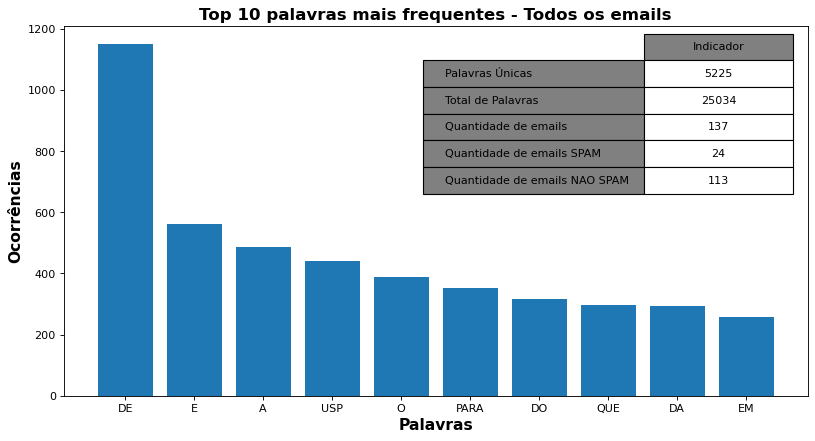

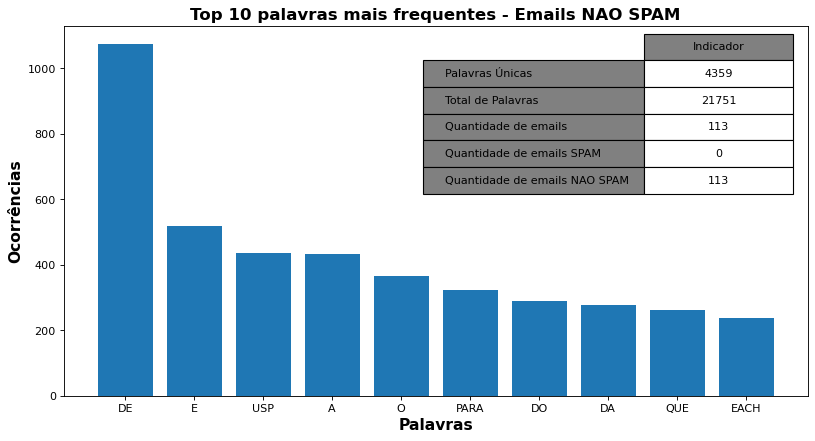

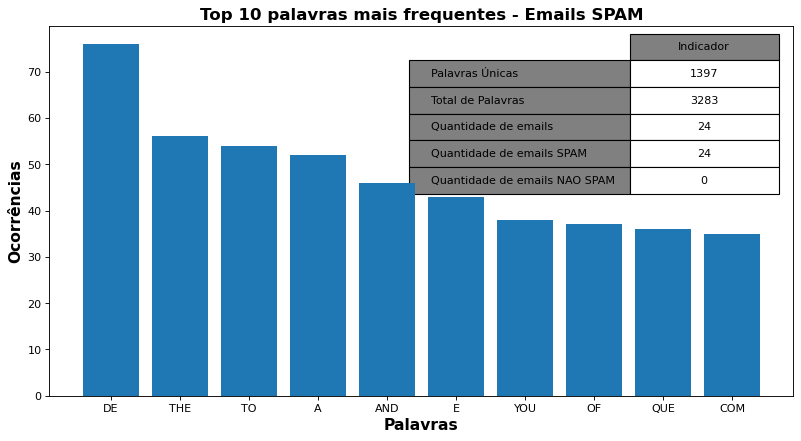

In [85]:
plotar_grafico_top_10(todos_emails,'Todos os emails')
plotar_grafico_top_10(emails_entrada,'Emails NAO SPAM')
plotar_grafico_top_10(emails_spam,'Emails SPAM')

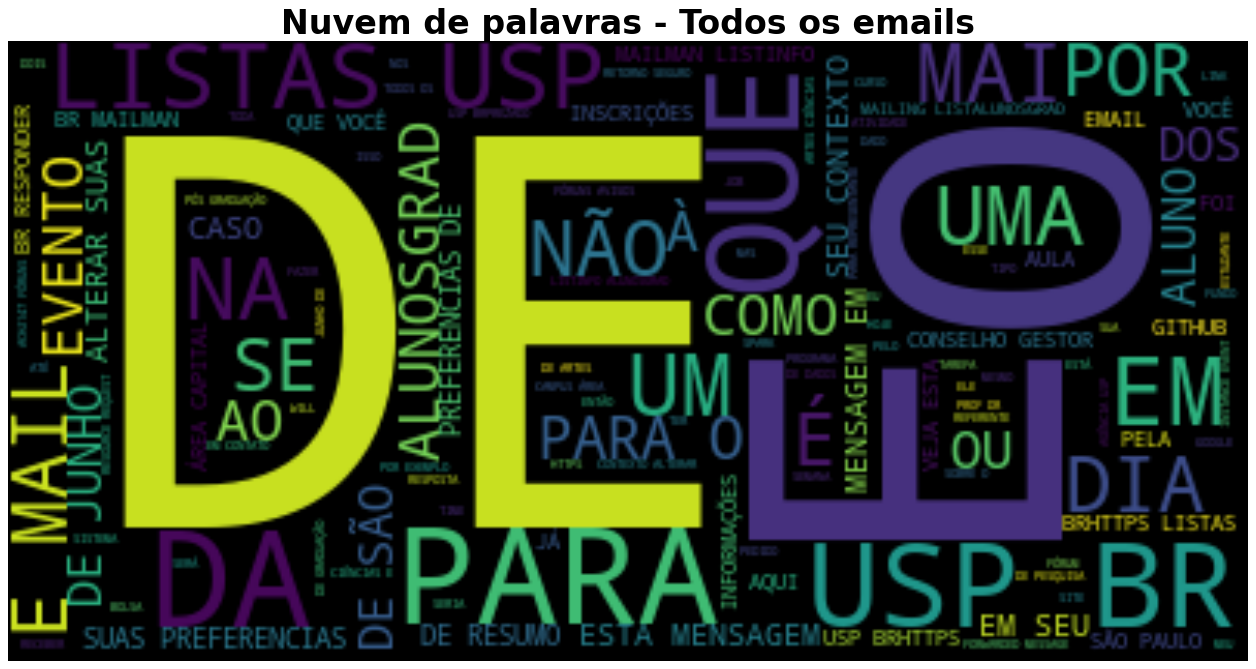

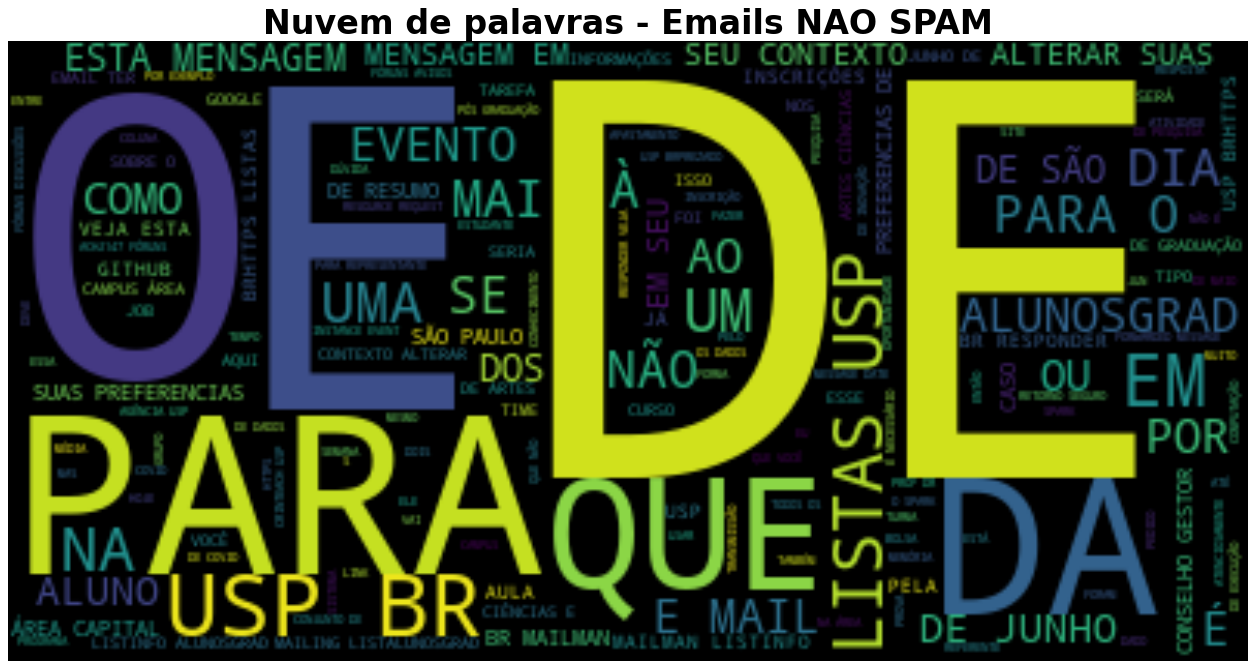

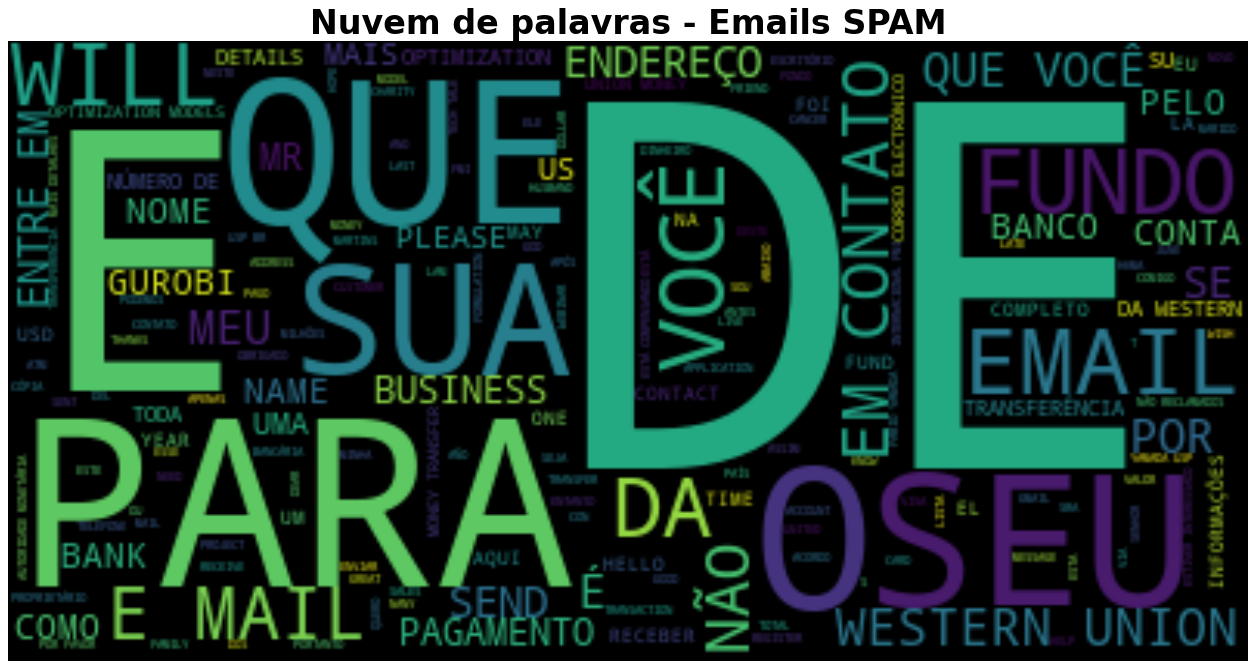

In [86]:
# gera uma nuvem de palavras
vetores_arr = uniao_vetores_com_repeticao(lista_emails=todos_emails[:,0])
gera_nuvem_palavras(vetores_arr,'Todos os emails')

vetores_arr = uniao_vetores_com_repeticao(lista_emails=emails_entrada[:,0])
gera_nuvem_palavras(vetores_arr,'Emails NAO SPAM')

vetores_arr = uniao_vetores_com_repeticao(lista_emails=emails_spam[:,0])
gera_nuvem_palavras(vetores_arr,'Emails SPAM')

# Separar Base de Treinamento e Teste. Treinamento 80% e teste 20% dos emails

In [87]:
arr_treinamento, arr_teste = split_base(todos_emails=todos_emails,porc_treinamento=.8)

In [88]:
print('TREINO')
print((arr_treinamento[:,1]=='NAO_SPAM').sum())
print((arr_treinamento[:,1]=='SPAM').sum())
print('TESTE')
print((arr_teste[:,1]=='NAO_SPAM').sum())
print((arr_teste[:,1]=='SPAM').sum())

TREINO
90
19
TESTE
23
5


# Treinar Spamminator no conjunto de treino (sem eliminar stopwords)

In [89]:
vetores_arr_treinamento = uniao_vetores(lista_emails=arr_treinamento[:,0])
df = pd.DataFrame(vetores_arr_treinamento.items(), columns=['Palavra','Quantidade'])
stop_words = df.sort_values(by=['Quantidade']).reset_index(drop=True)
stop_words = stop_words.reset_index(drop=False)
stop_words = stop_words[['Palavra','Quantidade','index']]
print('Quantidade de palavras na base de treinamento = {}'.format(stop_words.shape[0]))
stop_words_resultante = stop_words.values

# Treinamento do modelo!!!
# Cálculo das probabilidades priores (probabilidade de ser SPAM ou NAO_SPAM ) no conjunto de treinamento
# prob_hipoteses, prob_cond_atr_presenca_hip = calculo_probabilidades(arr_treinamento,palavras_sem_stop_words = palavras_sem_stop_words['Palavra'].values)
prob_hipoteses, prob_cond_atr_presenca_hip = calculo_probabilidades(arr_treinamento,palavras_sem_stop_words = stop_words_resultante[:,0])

Quantidade de palavras na base de treinamento = 4710


In [90]:
# Para prever
# 1 - para cada instancia do teste, transformar em um vetor baseado no vetor base do treinamento
# 2 - calcular a probabilidade de ser h1 com base no vetor resultante acima
# 3 - calcular a probabilidade de ser h2 com base no vetor resultante acima
# 4 - verificar qual o maior entre (2) e (3)
# 5 - previsao será a hipótese resultante de (4)

p_h_porcentagem, arr_previsao = previsao(stop_words_resultante,arr_teste,prob_hipoteses, prob_cond_atr_presenca_hip)

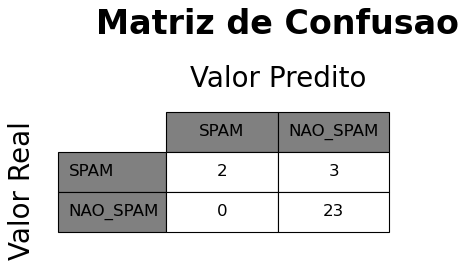

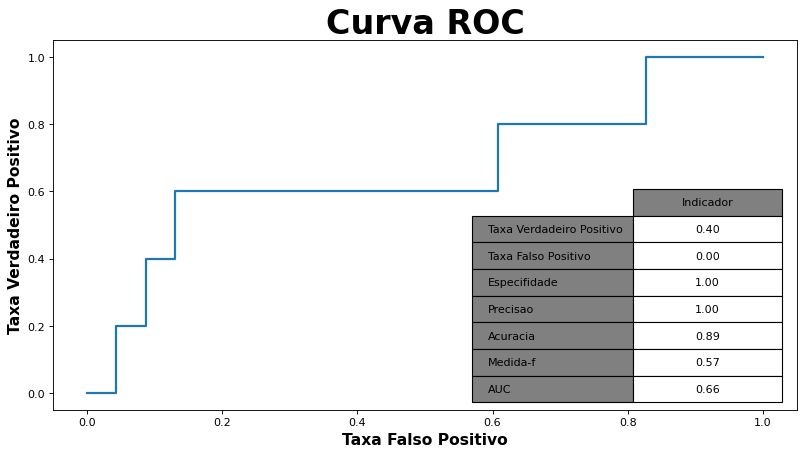

In [91]:
gerar_matriz_confusao_outros_indicadores_curva_ROC(arr_previsao, arr_teste, p_h_porcentagem)

In [92]:
2/5

0.4

# Curva de Aprendizagem

In [93]:
# Gero a curva de aprendizagem com base nos email sem retirar stop words
# gerar_curva_aprendizagem(todos_emails)

# Remover stopwords

In [94]:
vetores_arr_treinamento = uniao_vetores(lista_emails=arr_treinamento[:,0])
df = pd.DataFrame(vetores_arr_treinamento.items(), columns=['Palavra','Quantidade'])
stop_words = df.sort_values(by=['Quantidade']).reset_index(drop=True)
stop_words = stop_words.reset_index(drop=False)
stop_words = stop_words[['Palavra','Quantidade','index']]
print('Quantidade de palavras na base de treinamento = {}'.format(stop_words.shape[0]))

Quantidade de palavras na base de treinamento = 4710


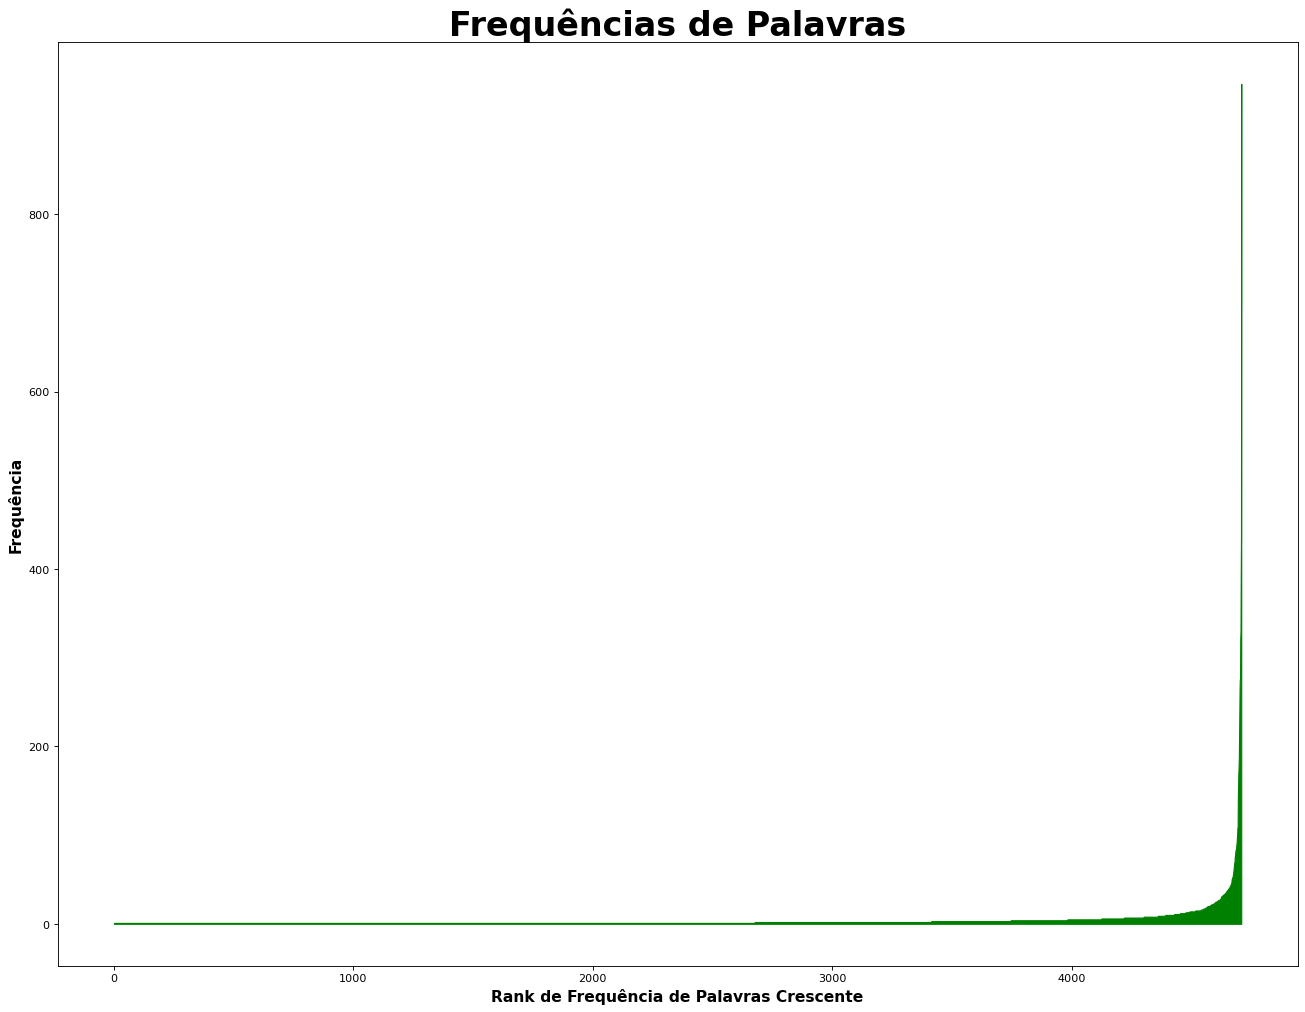

Ha muitas palavras e é nítido que no início temos uma concentração muito grande de palavras que se repetem muitas vezes. Provavelmente são artigos, preposições, etc.


In [95]:
# Create data
x=range(0,stop_words['Quantidade'].shape[0])
y=stop_words['Quantidade']

# Area plot
plt.figure(figsize=(20, 15), dpi=80)
plt.fill_between(x, y,color='green')
plt.title('Frequências de Palavras',fontdict = {'fontsize':30,'fontweight':'bold'})
plt.xlabel('Rank de Frequência de Palavras Crescente',fontdict = {'fontsize':14,'fontweight':'bold'})
plt.ylabel('Frequência',fontdict = {'fontsize':14,'fontweight':'bold'})

plt.show()
print('Ha muitas palavras e é nítido que no início temos uma concentração muito grande de palavras que se repetem muitas vezes. Provavelmente são artigos, preposições, etc.')

In [96]:
# # gera uma string unica com o array resultante
# texto = ' '.join(stop_words['Palavra'].values)
# wordcloud = WordCloud().generate(texto)

# # plota a nuvem de palavras:
# plt.figure(figsize=(20, 15), dpi=80)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

In [97]:
print(stop_words.shape)


stop_words_resultante = stop_words.values

palavras_unicas_qtd_palavras = []

stop_words_resultante_evolucao = []

palavras_unicas_qtd_palavras.append([stop_words_resultante.shape[0], stop_words_resultante[:,1].sum(),'Original'])
stop_words_resultante_evolucao.append(stop_words_resultante)
# Eliminar palavras atraves de identificacao de padroes

# Eliminar stop words padroes do portugues
path = 'stopwords_portugues.txt'
lista_stop_words = gera_lista_stop_words(path)
padrao_busca = lambda x:x in lista_stop_words
resultado_true_false = remover_padroes_funcao(funcao_que_remove_um_padrao=padrao_busca,condicao_remocao = True,numpy_array=stop_words_resultante[:,0])
stop_words_resultante = stop_words_resultante[resultado_true_false]
print(stop_words_resultante.shape)
palavras_unicas_qtd_palavras.append([stop_words_resultante.shape[0], stop_words_resultante[:,1].sum(),'Eliminar stop words padroes\ndo portugues'])
stop_words_resultante_evolucao.append(stop_words_resultante)

# Eliminar stop words padroes do ingles
path = 'stopwords_ingles.txt'
lista_stop_words = gera_lista_stop_words(path)
padrao_busca = lambda x:x in lista_stop_words
resultado_true_false = remover_padroes_funcao(funcao_que_remove_um_padrao=padrao_busca,condicao_remocao = True,numpy_array=stop_words_resultante[:,0])
stop_words_resultante = stop_words_resultante[resultado_true_false]
print(stop_words_resultante.shape)
palavras_unicas_qtd_palavras.append([stop_words_resultante.shape[0], stop_words_resultante[:,1].sum(),'Eliminar stop words padroes\ndo ingles'])
stop_words_resultante_evolucao.append(stop_words_resultante)

# Eliminar palavras que possuem numeros
padrao_busca = r'[0-9]+'
resultado_true_false = remover_padroes_regex(padrao_busca=padrao_busca,numpy_array=stop_words_resultante[:,0])
stop_words_resultante = stop_words_resultante[resultado_true_false]
print(stop_words_resultante.shape)
palavras_unicas_qtd_palavras.append([stop_words_resultante.shape[0], stop_words_resultante[:,1].sum(),'Eliminar palavras que possuem\nnumeros'])
stop_words_resultante_evolucao.append(stop_words_resultante)

# Eliminar palavras que possuem sequencia de a partir de 3 consoantes
padrao_busca = r'[BCDFGHJKLMNPQRSTVWXYZ]{4,}'
resultado_true_false = remover_padroes_regex(padrao_busca=padrao_busca,numpy_array=stop_words_resultante[:,0])
stop_words_resultante = stop_words_resultante[resultado_true_false]
print(stop_words_resultante.shape)
palavras_unicas_qtd_palavras.append([stop_words_resultante.shape[0], stop_words_resultante[:,1].sum(),'Eliminar palavras que possuem\nsequencia de a partir de 4 consoantes'])
stop_words_resultante_evolucao.append(stop_words_resultante)

# Eliminar palavras com 1 letra
padrao_busca = lambda x:len(x)
resultado_true_false = remover_padroes_funcao(funcao_que_remove_um_padrao=padrao_busca,condicao_remocao = 1,numpy_array=stop_words_resultante[:,0])
stop_words_resultante = stop_words_resultante[resultado_true_false]
print(stop_words_resultante.shape)
palavras_unicas_qtd_palavras.append([stop_words_resultante.shape[0], stop_words_resultante[:,1].sum(),'Eliminar palavras com 1 letra'])
stop_words_resultante_evolucao.append(stop_words_resultante)


(4710, 3)
(4581, 3)
(4491, 3)
(4175, 3)
(4104, 3)
(4088, 3)


In [98]:
# stop_words['Quantidade Acumulada (%)'] = gera_serie_porcentagem_acumulada(stop_words['Quantidade'])
arr_porc_acumulada = gera_serie_porcentagem_acumulada(stop_words_resultante[:,1])

# une a columa de porcentagem acumulada ao array 
stop_words_resultante = np.append(stop_words_resultante,arr_porc_acumulada.reshape(-1,1),axis=1)

frequencia_maxima = 0.7
qtd_minima = 3
# palavras_sem_stop_words = stop_words[stop_words['Quantidade Acumulada (%)']<=frequencia_maxima]
stop_words_resultante = stop_words_resultante[stop_words_resultante[:,3]<=frequencia_maxima]
palavras_unicas_qtd_palavras.append([stop_words_resultante.shape[0], stop_words_resultante[:,1].sum(),'Eliminar palavras com frequencia\nabaixo de {}'.format(frequencia_maxima)])
stop_words_resultante_evolucao.append(stop_words_resultante)

stop_words_resultante = stop_words_resultante[stop_words_resultante[:,1]>=qtd_minima]
palavras_unicas_qtd_palavras.append([stop_words_resultante.shape[0], stop_words_resultante[:,1].sum(),'Eliminar palavras com ocorrencia\nmenor do que {}'.format(qtd_minima)])
stop_words_resultante_evolucao.append(stop_words_resultante)


print('Considerando apenas as palavras com frequência abaixo de {0:.3g} %'.format(frequencia_maxima*100))
print('Temos agora {0:.3g} % das palavras do conjunto de dados original'.format(100*stop_words_resultante.shape[0]/stop_words.shape[0]))
print('Agora o tamanho do vocabulario do conjunto de treinamento é de {}'.format(stop_words_resultante.shape[0]))

Considerando apenas as palavras com frequência abaixo de 70 %
Temos agora 19.3 % das palavras do conjunto de dados original
Agora o tamanho do vocabulario do conjunto de treinamento é de 911


In [99]:
len(stop_words_resultante_evolucao)

8

In [100]:
arr_R_etapas = []
for stop_words_resultante_interacao in stop_words_resultante_evolucao:

    prob_hipoteses, prob_cond_atr_presenca_hip = calculo_probabilidades(arr_treinamento,palavras_sem_stop_words = stop_words_resultante_interacao[:,0])
    # Para prever
    # 1 - para cada instancia do teste, transformar em um vetor baseado no vetor base do treinamento
    # 2 - calcular a probabilidade de ser h1 com base no vetor resultante acima
    # 3 - calcular a probabilidade de ser h2 com base no vetor resultante acima
    # 4 - verificar qual o maior entre (2) e (3)
    # 5 - previsao será a hipótese resultante de (4)

    p_h_porcentagem, arr_previsao = previsao(stop_words_resultante_interacao,arr_teste, prob_hipoteses, prob_cond_atr_presenca_hip)
    arr_R, AUC = gera_matriz_curva_ROC(p_h_porcentagem,arr_teste)
    arr_R_etapas.append(arr_R)

1


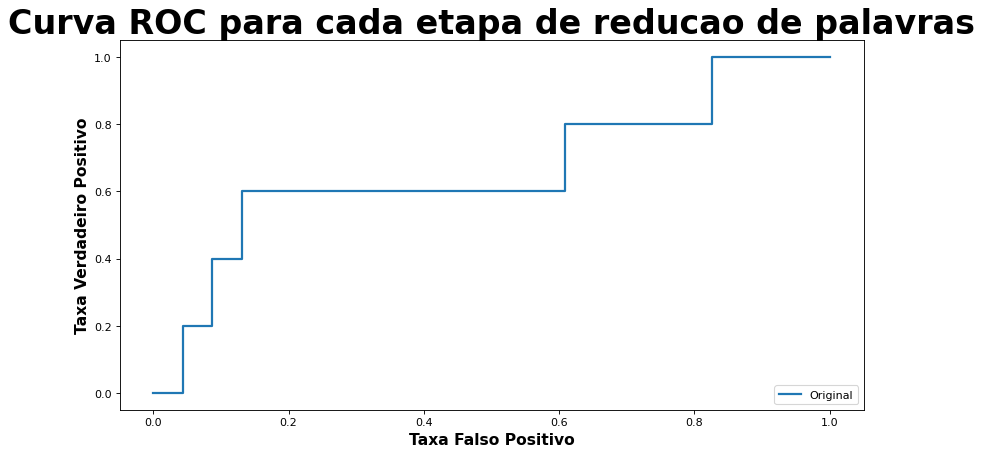

2


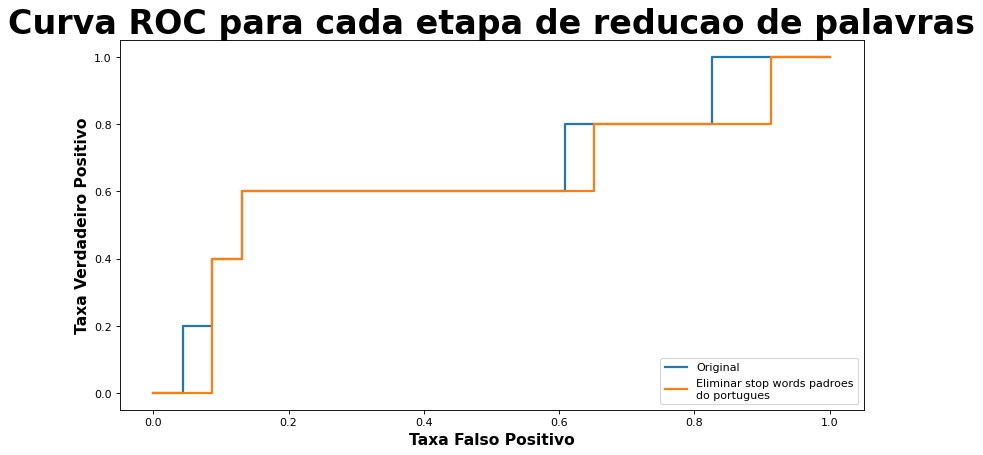

3


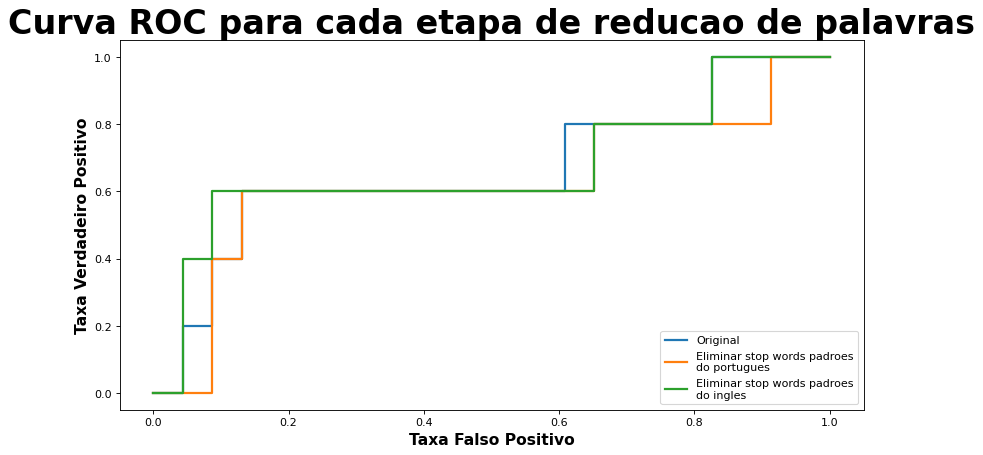

4


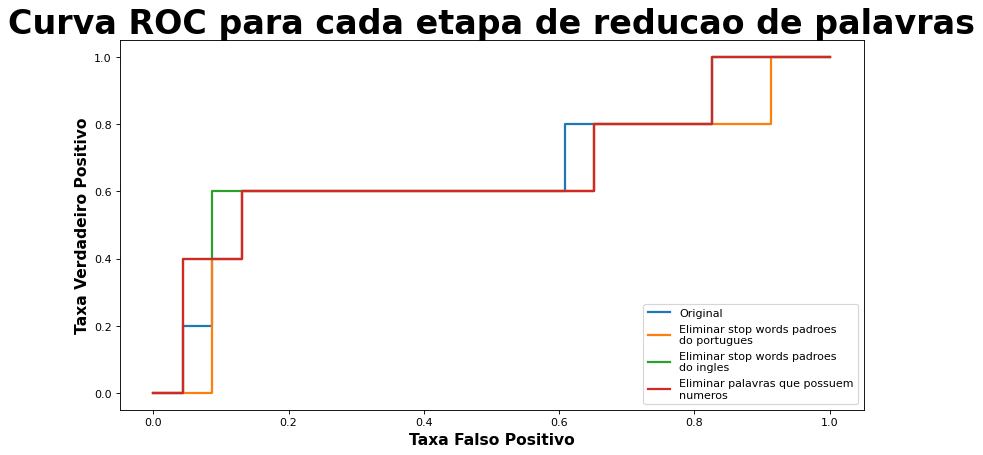

5


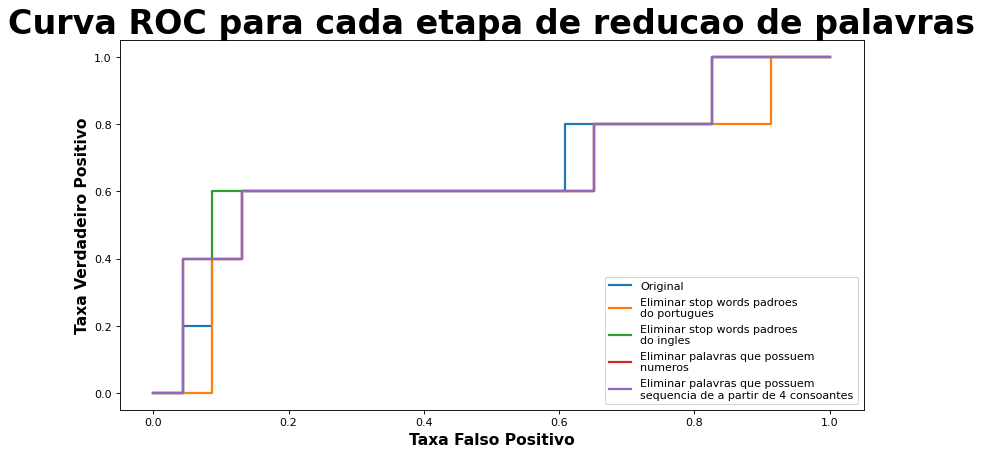

6


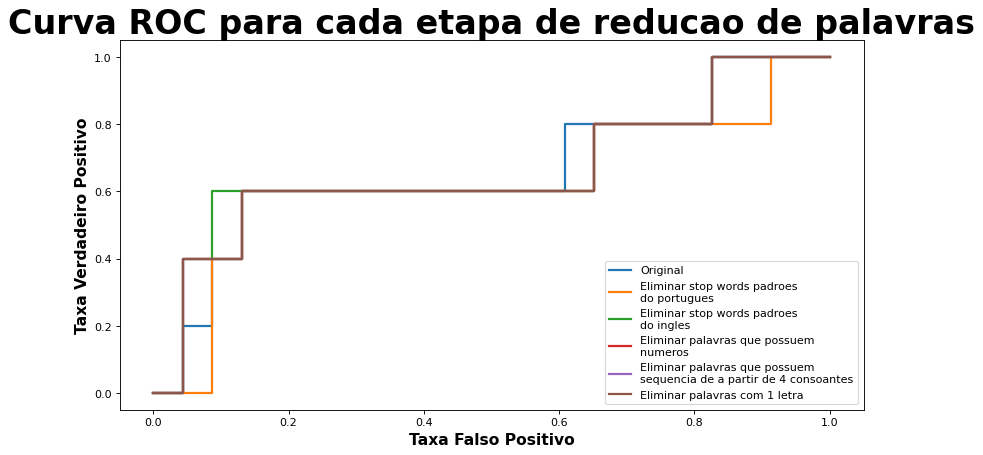

7


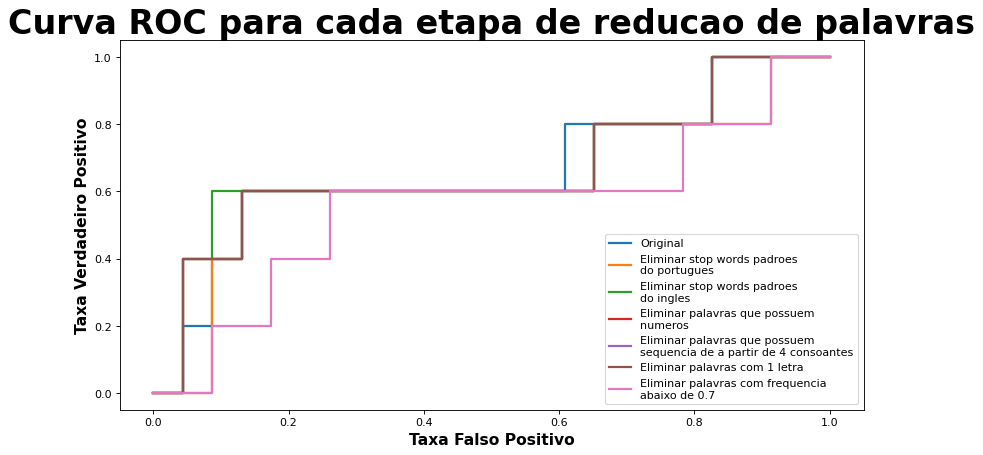

8


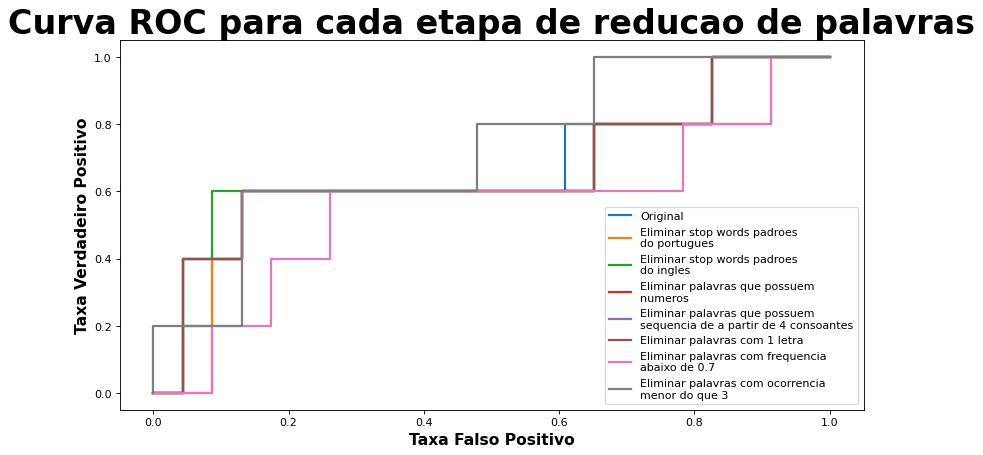

In [101]:
for ultimo in range(1,len(arr_R_etapas)+1):
    print(ultimo)
    fig = plt.figure(figsize=(12, 6), dpi=80)
    ax = fig.add_subplot(111) 

    for i,arr_R_iteracao in enumerate(arr_R_etapas[:ultimo]):
        plt.plot(arr_R_iteracao[:,0], arr_R_iteracao[:,1], linewidth=2, label=palavras_unicas_qtd_palavras[i][2])
        ax.legend(loc='lower right')

    legenda = [
        ['Palavras Únicas',1],
        ['Total de Palavras',2],
        ['Quantidade de emails',3],
        ['Quantidade de emails SPAM',4],
        ['Quantidade de emails NAO SPAM',5],
    ]

    plt.xlabel('Taxa Falso Positivo',fontdict = {'fontsize':14,'fontweight':'bold'})
    plt.ylabel('Taxa Verdadeiro Positivo',fontdict = {'fontsize':14,'fontweight':'bold'})
    plt.title('Curva ROC para cada etapa de reducao de palavras',fontdict = {'fontsize':30,'fontweight':'bold'})

    plt.show()

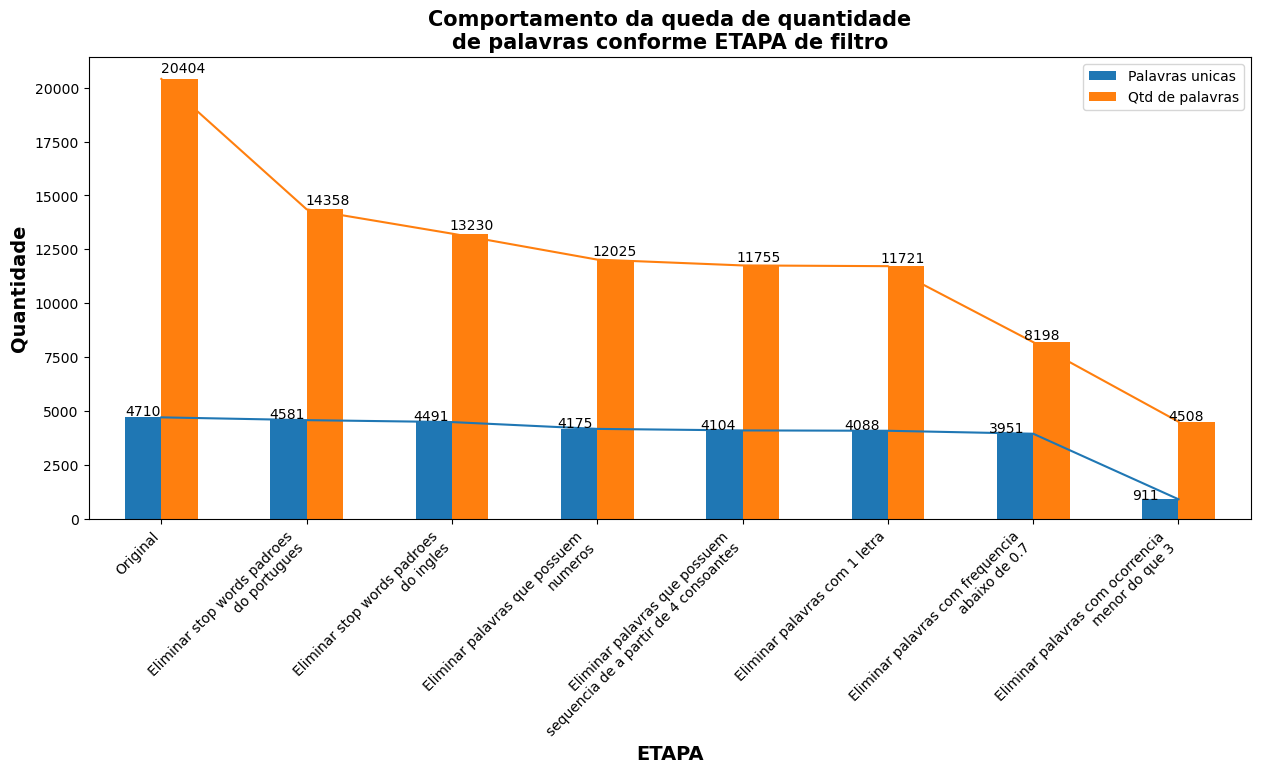

In [102]:
# Plotar a evolucao da queda de quantidade de palavras ao longo dos filtros
df = pd.DataFrame(palavras_unicas_qtd_palavras,columns=['Palavras unicas','Qtd de palavras','Metodo de exclusao'])
ax = df.plot(kind='bar')
df.plot(ax=ax, legend=False, figsize=(15,6))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 0.990, p.get_height() * 1.015))
plt.xticks(
    ticks= np.arange(len(palavras_unicas_qtd_palavras)),
    labels=df['Metodo de exclusao'].values,
    rotation=45,
    horizontalalignment='right')
plt.title('Comportamento da queda de quantidade\nde palavras conforme ETAPA de filtro',fontdict = {'fontsize':15,'fontweight':'bold'})
plt.ylabel('Quantidade',fontdict = {'fontsize':14,'fontweight':'bold'})
plt.xlabel('ETAPA',fontdict = {'fontsize':14,'fontweight':'bold'})    
plt.show()

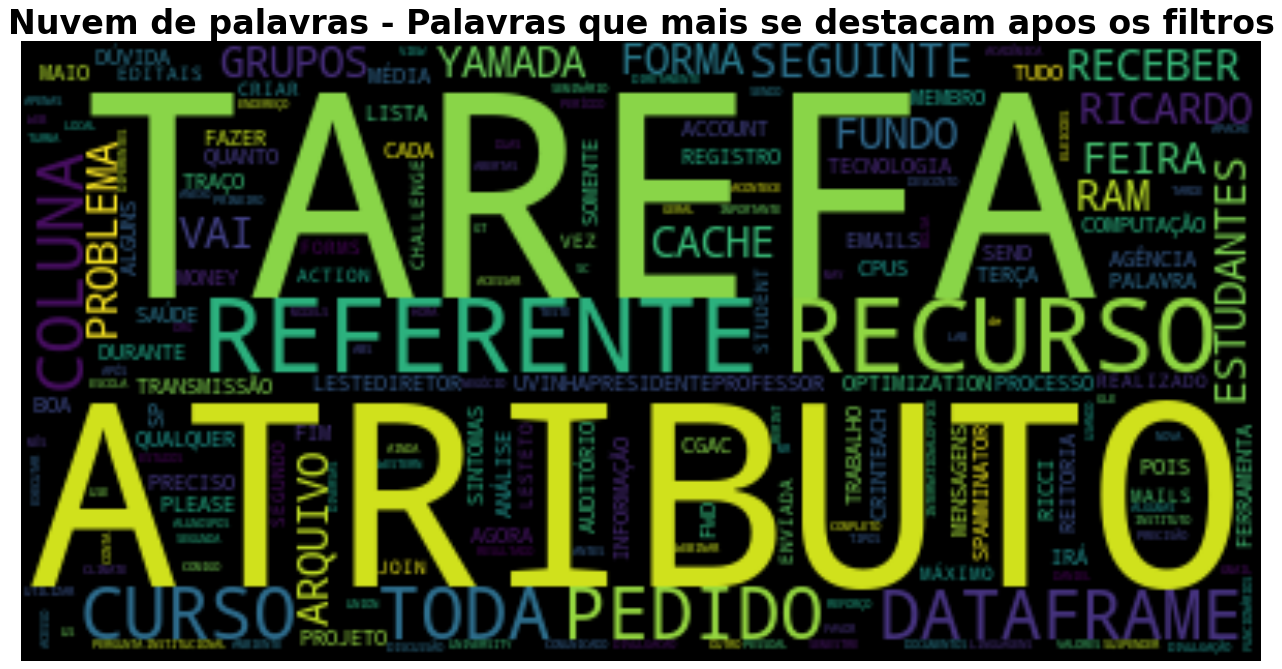

In [103]:
# Estrutura em um array as novas palavras
# Preciso fazer apenas um esquema de repetir neste array as palavras propositalmente para poder gerar a nuvem de palavras
texto = ' '.join((stop_words_resultante[:,0] + ' ' ) * stop_words_resultante[:,1])
arr_texto = np.array(texto.split(' '))
np.random.shuffle(arr_texto)

# ploto a nuvem de palavras
gera_nuvem_palavras(arr_texto,'Palavras que mais se destacam apos os filtros')

# Construção do Spammitator, usando o modelo Bayesiano Ingênuo

In [104]:
# Treinamento do modelo!!!
# Cálculo das probabilidades priores (probabilidade de ser SPAM ou NAO_SPAM ) no conjunto de treinamento
# prob_hipoteses, prob_cond_atr_presenca_hip = calculo_probabilidades(arr_treinamento,palavras_sem_stop_words = palavras_sem_stop_words['Palavra'].values)
prob_hipoteses, prob_cond_atr_presenca_hip = calculo_probabilidades(arr_treinamento,palavras_sem_stop_words = stop_words_resultante[:,0])

In [105]:
# Para prever
# 1 - para cada instancia do teste, transformar em um vetor baseado no vetor base do treinamento
# 2 - calcular a probabilidade de ser h1 com base no vetor resultante acima
# 3 - calcular a probabilidade de ser h2 com base no vetor resultante acima
# 4 - verificar qual o maior entre (2) e (3)
# 5 - previsao será a hipótese resultante de (4)

p_h_porcentagem, arr_previsao = previsao(stop_words_resultante,arr_teste, prob_hipoteses, prob_cond_atr_presenca_hip)

In [106]:
# Cálculo da acuracidade sobre o conjunto de teste
# print('Acuracidade foi de {0:.5}%'.format(100*retorna_acuracidade(arr_previsao,arr_teste[:,1])))

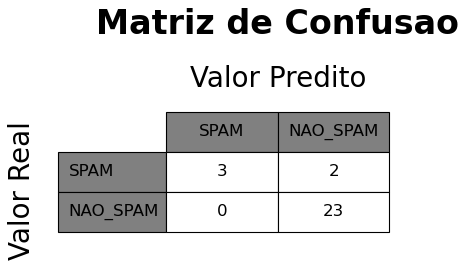

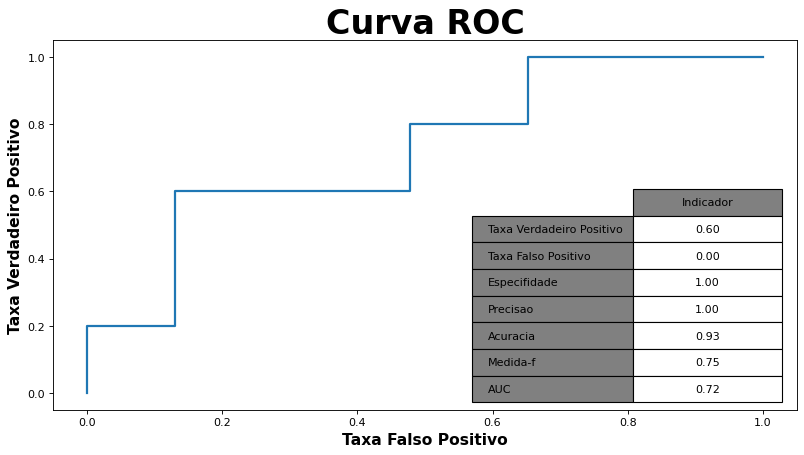

In [107]:
gerar_matriz_confusao_outros_indicadores_curva_ROC(arr_previsao, arr_teste, p_h_porcentagem)